#Imports

In [ ]:
#support libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix


#tensor flow
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

#convolution matrix
import seaborn as sns

#Data preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load dataset
filepath = "/content/drive/MyDrive/IoT-23 Dataset/iot23_combined_complete.csv"
df = pd.read_csv(filepath)

df
del df['Unnamed: 0'] ## a usueless column created by reading a cvs file

<ipython-input-4-5f2f42f0df24>:3: DtypeWarning: Columns (10,13,16,17,18,20,21,22,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


In [ ]:
df

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_icmp,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,2.998796,0,0,0.0,3.0,180.0,0.0,0.0,PartOfAHorizontalPortScan,False,...,False,False,False,True,False,False,False,False,False,False
1,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,False,...,False,False,False,True,False,False,False,False,False,False
2,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,False,...,False,False,False,True,False,False,False,False,False,False
3,2.998804,0,0,0.0,3.0,180.0,0.0,0.0,Benign,False,...,False,False,False,True,False,False,False,False,False,False
4,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444669,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,Benign,-1,...,-1,-1,-1,True,-1,-1,-1,False,-1,-1
1444670,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,-1,...,-1,-1,-1,True,-1,-1,-1,False,-1,-1
1444671,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,-1,...,-1,-1,-1,True,-1,-1,-1,False,-1,-1
1444672,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,-1,...,-1,-1,-1,True,-1,-1,-1,False,-1,-1


In [ ]:
##Transform False/True data into numbers
columns = [9, 12, 15, 16, 17, 19, 20, 21, 23, 24]

#object to bool
for col in df.columns[columns]:
     df[col] = df[col].replace(-1, False)
     df[col] = df[col].astype(bool)

#bool to int
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

df.dtypes

,0
duration,float64
orig_bytes,int64
resp_bytes,int64
missed_bytes,float64
orig_pkts,float64
orig_ip_bytes,float64
resp_pkts,float64
resp_ip_bytes,float64
label,object
proto_icmp,int64


In [ ]:
## Transforming analomalies into 1 and benign data into 0
print(df['label'].value_counts())
df['label'] = df['label'].apply(lambda x: 0 if x == "Benign" else 1)
y = df['label']

y
print(df['label'].value_counts())

label
PartOfAHorizontalPortScan     825939
Okiru                         262690
Benign                        197809
DDoS                          138777
C&C                            15100
Attack                          3915
C&C-HeartBeat                    349
C&C-FileDownload                  43
C&C-Torii                         30
FileDownload                      13
C&C-HeartBeat-FileDownload         8
C&C-Mirai                          1
Name: count, dtype: int64
label
1    1246865
0     197809
Name: count, dtype: int64


In [ ]:
## Normalization tecnique
X = df.drop(columns=['label'])
y = df['label']

scalar = MinMaxScaler()
scalar.fit(X)
X_normalized = scalar.transform(X)

In [ ]:
##Dataset split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.20, random_state=40)

#Divide into anomaly and beging data
X_train_begign = X_train[~y_train]
X_test_benign = X_test[~y_test]

X_train_anomaly = X_train[y_train]
X_test_anomaly = X_test[y_test]

#Test data has been split, but was never actually used in our code
y_train_benign = y_train[y_train == 1]

# Classic Autoencoder


In [ ]:
# REFERENCE:
# https://en.wikipedia.org/wiki/Autoencoder
# https://www.geeksforgeeks.org/auto-encoders/
# IMPLEMENTATION GUIDE:
# https://www.tensorflow.org/tutorials/generative/autoencoder

In [ ]:
class Autoencoders(tf.keras.Model):
    def __init__(self, input_dim, latent_dim=3):
        # Encoders: we follow a sequential dimensionality reduction: 24, 12, 6, 3
        super(Autoencoders, self).__init__()
        self.encoder = Sequential([
            layers.InputLayer(shape=(input_dim,)),
            layers.Dense(12, activation='relu'),
            layers.Dense(6, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
        ])

        # Decoder: opposite of encoder: 3, 6, 12, 24
        self.decoder = Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(6, activation='relu'),
            layers.Dense(12, activation='relu'),
            layers.Dense(input_dim, activation='sigmoid')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

# Regularization: EarlyStopping
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor val_loss
    patience=5,          # numbers of epochs until stop
    verbose=1,           # to print messages
    restore_best_weights=True  # restore best weight after training
)
# Create autoencoder instance
autoencoder = Autoencoders(input_dim=X_train.shape[1], latent_dim=3)

# Compile model
autoencoder.compile(optimizer= Adam(), loss = 'mae')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
autoencoder.summary()
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "autoencoders_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)           │ (None, 3)                   │             399 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_15 (Sequential)           │ (None, 24)                  │             420 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 819 (3.20 KB)

 Trainable params: 819 (3.20 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_189 (Dense)                    │ (None, 12)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_190 (Dense)                    │ (None, 6)                   │              78 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_191 (Dense)                    │ (None, 3)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 399 (1.56 KB)

 Trainable params: 399 (1.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_192 (Dense)                    │ (None, 6)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_193 (Dense)                    │ (None, 12)                  │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_194 (Dense)                    │ (None, 24)                  │             312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420 (1.64 KB)

 Trainable params: 420 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#comperison among epochs
## fit format: https://www.tensorflow.org/api_docs/python/tf/keras/Model
# p1: x --> input
# p2: y --> target data, in our case: same, we are developing autoencoders

# p3: batchsize, default = 32. We are setting to 256, as done in CNN for previous project.
# It is a good balanced for effiecency and accuracy

# p4: epochs. We can perform eraly stopping tencnique and see which is the best one
# p5: validation_data: Data on which to evaluate the loss and any model metrics at the end of each epoch
# --> in our case x_test, x_test
# --> created on the full dataset, so anomaly + normal data

history_classical_autoencoder = autoencoder.fit(X_train_begign, X_train_begign,
                                                epochs=10,
                                                shuffle=True,
                                                batch_size=256,
                                                validation_data=(X_test, X_test),
                                                callbacks=[early_stopping]
                                                )

Epoch 1/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0478 - val_loss: 0.0255
Epoch 2/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 1.3947e-06 - val_loss: 0.0254
Epoch 3/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 8.1380e-08 - val_loss: 0.0254
Epoch 4/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 8.5031e-09 - val_loss: 0.0254
Epoch 5/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 1.3046e-09 - val_loss: 0.0254
Epoch 6/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 6.3921e-10 - val_loss: 0.0254
Epoch 7/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 5.6757e-10 - val_loss: 0.0254
Epoch 8/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 5.3971e-10 - val_loss: 0.0254
Epoch 9/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 5.3536e-10 - val_loss: 0.0254
Epoch 10/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 5.2673e-10 - val_loss: 0.0254
Restoring model weights from the end of the best epoch: 10.


# Variational Autoencoder

In [ ]:
#Encoder class
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim= 3):
        super(Encoder, self).__init__()
        self.dense1 = layers.Dense(24, activation='relu')
        self.dense2 = layers.Dense(12, activation='relu')
        self.dense3 = layers.Dense(6, activation='relu')
        #create two different parallel layers to calculate mean and log_var
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(6, activation='relu')
        self.dense2 = layers.Dense(12, activation='relu')
        self.output_layer = layers.Dense(original_dim, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

In [ ]:
def sampling(mean, log_var):
    # https://www.tensorflow.org/api_docs/python/tf/random/normal
    epsilon = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log_var) * epsilon

In [ ]:
class VAE(tf.keras.Model):
    #Create an VAE autoencoder
    def __init__(self, latent_dim, original_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)

    #Move data flow among NN
    def call(self, inputs):
        mean, log_var = self.encoder(inputs)
        z = sampling(mean, log_var)
        return self.decoder(z)
    #We have created our specific loss function in our model

    def compute_loss(self, inputs, reconstructed, mean, log_var):
        # two types of losses:
        # 1. This term measures the dissimilarity between the original input and its reconstruction produced by the decoder
        # examples = MSE
        # 2. KL Divergence Loss: https://kvfrans.com/deriving-the-kl/
        # This term quantifies the divergence between the learned  latent variable distribution (posterior)
        # and the prior distribution (typically a standard normal distribution).
        reconstruction_loss = tf.reduce_sum(tf.square(inputs - reconstructed))
        # kl_loss = sampling(mean, log_var)
        return reconstruction_loss

    #Override train_step to integrate the loss and backpropagation
    def train_step(self, data):
        # Data are what is given i .fit as x,y. In our case x = X_train, y = Y_train
        x_batch_train, _ = data  # Assuming data is in the form (input, target), here we use input as both
        with tf.GradientTape() as tape:
            # Forward pass
            mean, log_var = self.encoder(x_batch_train)
            z = sampling(mean, log_var)
            reconstructed = self.decoder(z)

            # Compute loss
            loss = self.compute_loss(x_batch_train, reconstructed, mean, log_var)

        # Compute gradients
        grads = tape.gradient(loss, self.trainable_variables)

        # Apply gradients to update the model weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {'loss': loss}


In [ ]:
vae = VAE(latent_dim=3, original_dim=X_train.shape[1])

encoder = Encoder(latent_dim=3)
decoder = Decoder(original_dim=X_train.shape[1])
encoder.summary()
decoder.summary()

Model: "encoder_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_203 (Dense)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_204 (Dense)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_205 (Dense)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_206 (Dense)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_207 (Dense)                    │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_208 (Dense)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_209 (Dense)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_210 (Dense)                    │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Vae creation
# compiling a model means preparing it for training by setting up the necessary
# components that will allow the model to optimize its weights and learn from the data
# We can specify:
# compile, loss function, metrics
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss = VAE.compute_loss)

history_vae = vae.fit(
    X_train_begign, X_train_begign,
    epochs=10,
    shuffle=True,
    batch_size=256,
    validation_data=(X_test, X_test)
)

Epoch 1/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 47.0076 - val_loss: 0.0000e+00
Epoch 2/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0041 - val_loss: 0.0000e+00
Epoch 3/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 2.6973e-04 - val_loss: 0.0000e+00
Epoch 4/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 2.1163e-05 - val_loss: 0.0000e+00
Epoch 5/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 1.7464e-06 - val_loss: 0.0000e+00
Epoch 6/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 1.5029e-07 - val_loss: 0.0000e+00
Epoch 7/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1.3653e-08 - val_loss: 0.0000e+00
Epoch 8/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 1.5353e-09 - val_loss: 0.0000e+00
Epoch 9/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 2.7033e-10 - val_loss: 0.0000e+00
Epoch 10/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 9.0163e-11 - val_loss: 0.0000e+00


# LSTM Autoencoder

In [ ]:
# REFERENCE:
# paper with same outcome and same database:
# https://www.sciencedirect.com/science/article/pii/S0140366421002164?casa_token=F-gYp9X_6BsAAAAA:Mb8CuXPrqJb9jmzu_ryqrfR7U4JCt-K6QBAesJCuE9MH-hODwjuSfI-TWBqLPmcQg5A_pw7Gfew

In [ ]:
# Useful video: https://www.youtube.com/watch?app=desktop&v=H4J74KstHTE
# LSMT:         https://www.youtube.com/watch?v=b61DPVFX03I

In [ ]:
#LSTM models expect 3D input, needs reshaping of data. LSTM expects (samples, time steps, features) format.
# X_train_benign shape =  (1155739, 1, 24)
# X_test shape =          (288935, 1, 24) --> change time steps?

X_train_benign = X_train_begign.reshape((X_train_begign.shape[0], 1, X_train_begign.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train_benign.shape)
print(X_test.shape)

(1155739, 1, 24)
(288935, 1, 24)


In [ ]:
#LSTM Autoencoder Model
class LSTMAutoencoder(tf.keras.Model):
    def __init__(self, timesteps, n_features, latent_dim):
        super(LSTMAutoencoder, self).__init__()

        # Encoder
        self.encoder = tf.keras.Sequential([
            # First LSTM layer with Dropout
            layers.LSTM(24, activation='relu', return_sequences=True, input_shape=(timesteps, n_features)),
            layers.Dropout(0.2),
            # Second LSTM layer with Dropout
            layers.LSTM(12, activation='relu', return_sequences=False),
            layers.Dropout(0.2),
            # Bottleneck layer (latent space)
            layers.Dense(latent_dim, activation='relu')
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            # Repeat the bottleneck vector to match the input shape of the next layer
            layers.RepeatVector(timesteps),
            # LSTM layer to reconstruct the sequence
            layers.LSTM(12, activation='relu', return_sequences=True),
            layers.Dropout(0.2),
            # LSTM layer to match the number of features in the output
            layers.LSTM(24, activation='relu', return_sequences=True),
            layers.Dropout(0.2),
            # TimeDistributed Dense layer to reconstruct the sequence (output layer)
            layers.TimeDistributed(layers.Dense(n_features, activation='relu'))
        ])

    def call(self, inputs):
        # Encoder produces the latent representation
        latent = self.encoder(inputs)
        # Decoder reconstructs the sequence from the latent space
        reconstructed = self.decoder(latent)
        return reconstructed

# Input dimensions
timesteps = X_train_benign.shape[1]  # Set timesteps from your data
n_features = X_train_benign.shape[2]  # Set features from your data
latent_dim = 3  # Size of the bottleneck representation

# Instantiate and compile the model
lstm_autoencoder = LSTMAutoencoder(timesteps, n_features, latent_dim)
lstm_autoencoder.compile(optimizer='adam', loss='mae')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Training LSTM Model
history_lstm = lstm_autoencoder.fit(
    X_train_benign, X_train_benign,
    epochs=10,
    batch_size=256,
    validation_data=(X_test, X_test),
    shuffle=True
)

Epoch 1/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 0.0123 - val_loss: 0.0254
Epoch 2/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 1.0417e-04 - val_loss: 0.0256
Epoch 3/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 1.0751e-04 - val_loss: 0.0255
Epoch 4/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 1.0976e-04 - val_loss: 0.0255
Epoch 5/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 9.9568e-05 - val_loss: 0.0255
Epoch 6/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - loss: 9.6596e-05 - val_loss: 0.0255
Epoch 7/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 76s 8ms/step - loss: 1.0326e-04 - val_loss: 0.0255
Epoch 8/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 7.8173e-05 - val_loss: 0.0254
Epoch 9/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - loss: 7.5313e-05 - val_loss: 0.0254
Epoch 10/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 8.6319e-05 - val_loss: 0.0254


# LSTM Autoencoder Early stopping

In [ ]:
class LSTMAutoencoder:
    def __init__(self, input_dim=24, timesteps=1, latent_dim=8):
        self.input_dim = input_dim
        self.timesteps = timesteps
        self.latent_dim = latent_dim
        self.model = None
        self.threshold = None
        self.history = None

    def build_model(self):
        # Define input layer: timesteps, input_dim = 24
        inputs = Input(shape=(self.timesteps, self.input_dim))

        # Encoder
        encoded = LSTM(16, activation='relu', return_sequences=True)(inputs)
        encoded = LSTM(self.latent_dim, activation='relu')(encoded)

        # Latent space representation

        # Decoder
        decoded = RepeatVector(self.timesteps)(encoded)
        decoded = LSTM(self.latent_dim, activation='relu', return_sequences=True)(decoded)
        decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)

        # Output layer
        outputs = TimeDistributed(Dense(self.input_dim))(decoded)

        # Create the autoencoder model
        self.model = Model(inputs, outputs)
        self.model.compile(optimizer='adam', loss='mse')

        print(self.model.summary())
        return self.model

    def train(self, X_train, validation_data=None, epochs=10, batch_size=256):
        if self.model is None:
            self.build_model()

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ModelCheckpoint('lstm_autoencoder.h5', monitor='val_loss', save_best_only=True)
        ]

        # Reshape input data if needed
        if len(X_train.shape) == 2:
            X_train = X_train.reshape(X_train.shape[0], self.timesteps, self.input_dim)

        # Train the model
        self.history = self.model.fit(
            X_train, X_train,  # Autoencoder input = output
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data if validation_data else (X_train, X_train),
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def compute_reconstruction_errors(self, data):
        # Reshape input data if needed
        if len(data.shape) == 2:
            data = data.reshape(data.shape[0], self.timesteps, self.input_dim)

        # Get reconstructions
        reconstructions = self.model.predict(data)

        # Compute MSE for each sample
        mse = np.mean(np.power(data - reconstructions, 2), axis=(1, 2))

        return mse

    def set_threshold(self, X_train, contamination=0.01):
        reconstruction_errors = self.compute_reconstruction_errors(X_train)
        self.threshold = np.percentile(reconstruction_errors, 100 * (1 - contamination))
        return self.threshold

    def predict(self, X_test, threshold=None):
        if threshold is not None:
            self.threshold = threshold

        if self.threshold is None:
            raise ValueError("Threshold not set. Call set_threshold() first or provide a threshold value.")

        reconstruction_errors = self.compute_reconstruction_errors(X_test)
        y_pred = (reconstruction_errors > self.threshold).astype(int)

        return y_pred

    def evaluate(self, X_test, y_true):
        """
        Evaluate the model performance

        Args:
            X_test: Test data
            y_true: True labels (1 for anomaly, 0 for normal)

        Returns:
            Dictionary with performance metrics
        """
        y_pred = self.predict(X_test)

        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred)
        }

        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"F1-Score: {metrics['f1']:.4f}")

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Bening', 'Anomaly'],
                   yticklabels=['Bening', 'Anomaly'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # Generate and print classification report
        print("\nClassification Report:")
        report = classification_report(y_true, y_pred, target_names=['Beningn', 'Anomaly'])
        print(report)

        return metrics

    def plot_history(self):
        """Plot training history"""
        if self.history is None:
            print("No training history available.")
            return

        plt.figure(figsize=(10, 4))
        plt.plot(self.history.history['loss'], label='Training Loss')
        if 'val_loss' in self.history.history:
            plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

    def plot_reconstruction_errors(self, X_test, y_true=None):
        """Plot reconstruction errors with threshold"""
        errors = self.compute_reconstruction_errors(X_test)

        plt.figure(figsize=(10, 6))
        if y_true is not None:
            plt.scatter(range(len(errors)), errors, c=y_true, cmap='coolwarm', alpha=0.7)
            plt.colorbar(label='True Class')
        else:
            plt.scatter(range(len(errors)), errors, alpha=0.7)

        if self.threshold is not None:
            plt.axhline(y=self.threshold, color='r', linestyle='-', label=f'Threshold: {self.threshold:.4f}')
            plt.legend()

        plt.title('Reconstruction Errors')
        plt.ylabel('Reconstruction Error')
        plt.xlabel('Sample Index')
        plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 24)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 16)               │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 8)                │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 16)               │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 24)               │             408 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,976 (23.34 KB)

 Trainable params: 5,976 (23.34 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
4510/4515 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098

4515/4515 ━━━━━━━━━━━━━━━━━━━━ 49s 9ms/step - loss: 0.0098 - val_loss: 7.5617e-09
Epoch 2/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - loss: 6.1621e-09 - val_loss: 5.2765e-08
Epoch 3/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - loss: 2.9223e-08 - val_loss: 3.3155e-08
Epoch 4/10
4513/4515 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7448e-08

4515/4515 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - loss: 2.7449e-08 - val_loss: 2.1274e-11
Epoch 5/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - loss: 2.8665e-08 - val_loss: 8.4674e-10
Epoch 6/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 2.7939e-08 - val_loss: 2.4587e-07
Epoch 7/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 2.7175e-08 - val_loss: 4.7590e-11
36117/36117 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step
9030/9030 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
9030/9030 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
Accuracy: 0.7632
Recall: 0.8412
Precision: 0.8794
F1-Score: 0.8599


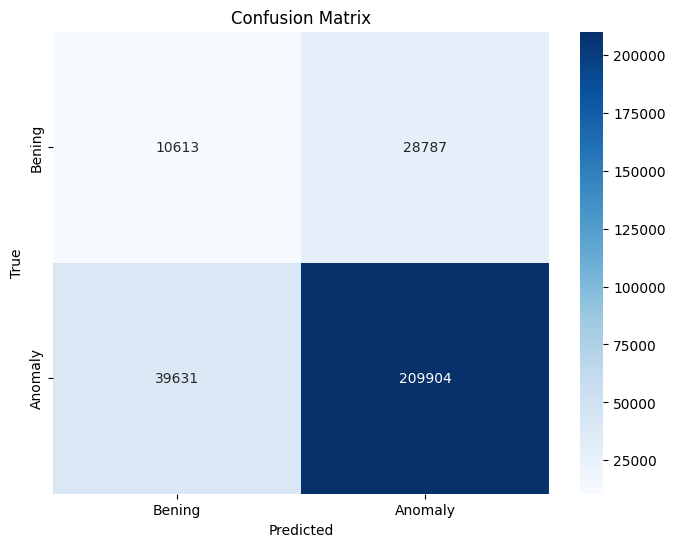


Classification Report:
              precision    recall  f1-score   support

     Beningn       0.21      0.27      0.24     39400
     Anomaly       0.88      0.84      0.86    249535

    accuracy                           0.76    288935
   macro avg       0.55      0.56      0.55    288935
weighted avg       0.79      0.76      0.77    288935



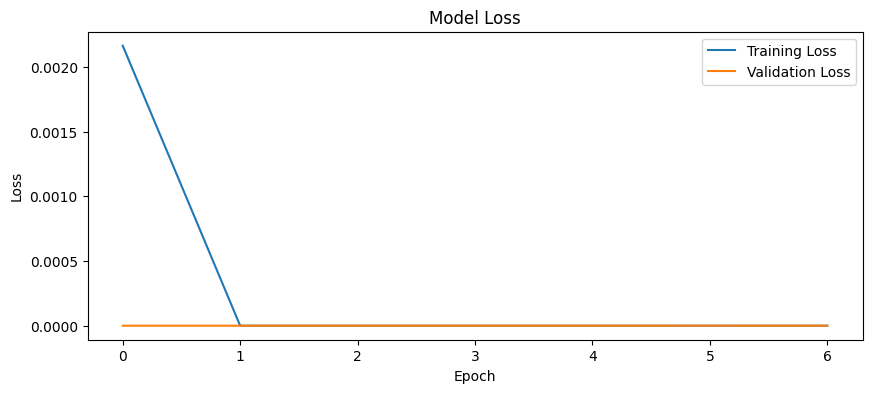

9030/9030 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


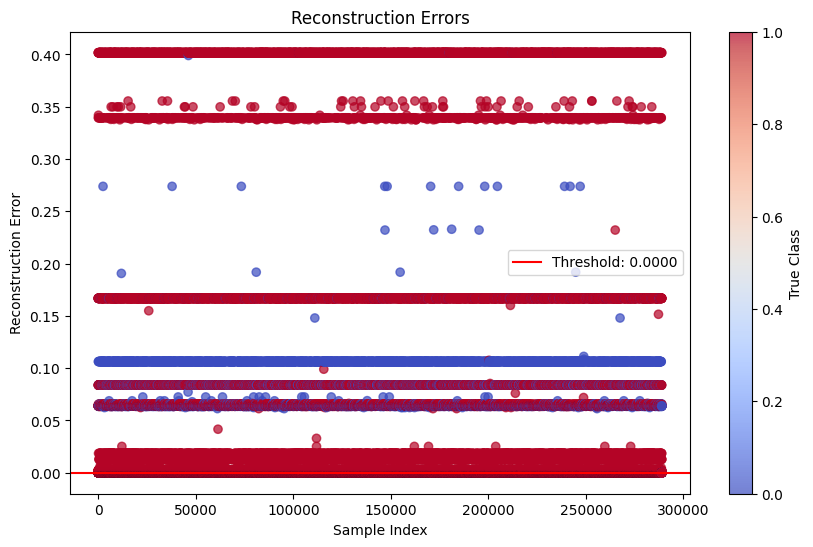

In [ ]:
# Initialize and train the model
autoencoder_LSMT = LSTMAutoencoder(input_dim=24, timesteps=1, latent_dim=8)
autoencoder_LSMT.build_model()
autoencoder_LSMT.train(X_train_begign, epochs=10, batch_size=256)

# Set threshold and make predictions
autoencoder_LSMT.set_threshold(X_train_begign, contamination=0.05)
y_pred = autoencoder_LSMT.predict(X_test)

# Evaluate model performance
metrics = autoencoder_LSMT.evaluate(X_test, y_test)

# Visualize results
autoencoder_LSMT.plot_history()
autoencoder_LSMT.plot_reconstruction_errors(X_test, y_test)




# GAN: Generative Adversial Autoencoders

In [ ]:
# Also GAN are useful for anomaly detection. To find out more: https://arxiv.org/pdf/1906.11632
# Tensorflow GUIDE IMPLEMENTATION: https://www.tensorflow.org/tutorials/generative/dcgan

# Some usuful blogs:
# https://medium.com/data-reply-it-datatech/detecting-the-unseen-anomaly-detection-with-gans-8b20f3056a11

In [ ]:
#Create latent space
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim=3):
        super(Encoder, self).__init__()

        # Fully connected layers
        self.fc1 = layers.Dense(24, activation='relu')
        self.fc2 = layers.Dense(12, activation='relu')
        self.fc3 = layers.Dense(12, activation='relu')
        self.fc4 = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        z = self.fc4(x)
        return z

encoder = Encoder(latent_dim=3)

latent_vectors = encoder(X_train_begign)

print(latent_vectors.shape) #It should be <all data, latent_dim>

(1155739, 3)


In [ ]:
class Generator(tf.keras.Model):
    # create a generator that starting from z recreates the 24 feature vector
    # We took a small reduction vector dim=3 as done in other implementations and
    # increment to 24 features
    def __init__(self, z_dim=3, input_dim=24):
        super(Generator, self).__init__()
        self.fc1 = layers.Dense(3, activation='relu')
        self.fc2 = layers.Dense(6, activation='relu')
        self.fc3 = layers.Dense(12, activation='relu')
        #why tanh this time? we've seen a paper comperison of activation function,
        #in this case it seems the best one: https://arxiv.org/pdf/2109.14545
        self.fc4 = layers.Dense(24, activation='relu')

    def call(self, z):
        x = self.fc1(z)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [ ]:
class Discriminator(tf.keras.Model):
    def __init__(self, z_dim=3, input_dim=24):
        super(Discriminator, self).__init__()

        # Discriminator NN
        self.dense1 = layers.Dense(24, activation='relu', input_dim=24)
        self.dense2 = layers.Dense(12, activation='relu')
        self.dense3 = layers.Dense(6, activation='relu')
        self.dense4 = layers.Dense(3, activation='relu')
        # Last layes is a probablity outcome, so we use a sigmoid as activation
        # function: https://en.wikipedia.org/wiki/Sigmoid_function
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.output_layer(x)

In [ ]:
# This function simply generate random points given a tensor.shape
def generate_latent_points(latent_dim, batch_size):
    return np.random.normal(0, 1, size=(batch_size, latent_dim))

In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, z_dim=3, input_dim=24):
        super(GAN, self).__init__()
        # Generator:
        # z_dim = latent space(3)
        # input_dim = feature vector(24)
        self.generator = Generator(z_dim, input_dim)
        # Discriminator
        # input_dim = feature vector(24 - output: 1
        self.discriminator = Discriminator(input_dim)

    # This is an advanced NN composed of other NN
    # So we have to choose different type of optimizer:
    # one for generator
    # one for discriminator
    # The loss function is unique
    def compile(self, generator_optimizer, discriminator_optimizer, loss_fn):
        super(GAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.loss_fn = loss_fn

    # Call function--> data flow in our NN
    # Generator --> feature vector of 24 ---> Discriminator --> (0,1) probability
    def call(self, inputs):
        x = self.generator(inputs)
        return self.discriminator(x)

    #https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    def train_step(self, data):
        # Create rumor from real data: https://www.tensorflow.org/api_docs/python/tf/random/normal
        # Function to generate random noise for the generator
        noise = generate_latent_points(latent_dim=3, batch_size=256)
        # Generates data calling self.generator(z)
        generated_data = self.generator(noise)

        x, _ = data
        # Discriminator training. The training is done on real_data.
        # TODO: generator schould start on FakeData maybe!!!
        with tf.GradientTape() as disc_tape:
            # Real data outcome
            real_output = self.discriminator(x)
            # Fake data outcome
            fake_output = self.discriminator(generated_data)

            # loss function of generator: https://medium.com/data-science/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
            # tf.ones_like = creates a tensor of all ones that has the same shape as the input https://www.tensorflow.org/api_docs/python/tf/ones_like
            # tf.zeros_like = creates a tensor of all zeros that has the same shape as the input https://www.tensorflow.org/api_docs/python/tf/zeros_like
            disc_loss = self.loss_fn(tf.ones_like(real_output), real_output) + \
                        self.loss_fn(tf.zeros_like(fake_output), fake_output)

        # Perform gradient discent for discriminator
        grads_disc = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(grads_disc, self.discriminator.trainable_variables))

        # Generator Training
        with tf.GradientTape() as gen_tape:
            # outcome of generator data --> Why repeate generated_data
            generated_data = self.generator(noise)
            # result of discriminator in fake data
            fake_output = self.discriminator(generated_data)

            # The idea of this loss function is this one:
            # The Generator should trick the discriminator, by assign all ones(real data)
            gen_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        # Perform gradient descent
        grads_gen = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(grads_gen, self.generator.trainable_variables))

        return {'gen_loss': gen_loss, 'disc_loss': disc_loss}

In [ ]:
#Latent space
z_dim = 3
# Feature vector
input_dim = 24
#Create our model
gan = GAN(z_dim, input_dim)

# Compile
# We have chosen Adam for both generator and discriminator.
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

# Why have you use beta_1? TO BE DONE
gan.compile(
    generator_optimizer=tf.keras.optimizers.Adam(),
    discriminator_optimizer=tf.keras.optimizers.Adam(),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Fit function for autoencoder
history_classical_autoencoder = gan.fit(X_train_begign, X_train_begign,
                                        epochs=10,
                                        shuffle=True,
                                        batch_size=256,
                                        )

gan.summary()

Epoch 1/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - disc_loss: 1.3342 - gen_loss: 0.7817
Epoch 2/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - disc_loss: 1.3801 - gen_loss: 0.7064
Epoch 3/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - disc_loss: 1.3652 - gen_loss: 0.7334
Epoch 4/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - disc_loss: 1.3752 - gen_loss: 0.7155
Epoch 5/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - disc_loss: 1.3840 - gen_loss: 0.7001
Epoch 6/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - disc_loss: 1.3763 - gen_loss: 0.7225
Epoch 7/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - disc_loss: 1.3705 - gen_loss: 0.7328
Epoch 8/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - disc_loss: 1.3661 - gen_loss: 0.7470
Epoch 9/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - disc_loss: 1.3814 - gen_loss: 0.7303
Epoch 10/10
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - disc_loss: 1.3863 - gen_loss: 0.6928


Model: "gan_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ generator_7 (Generator)              │ ?                           │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ discriminator_7 (Discriminator)      │ ?                           │           1,003 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,435 (5.61 KB)

 Trainable params: 1,435 (5.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gan.summary()
gan.discriminator.summary()
gan.generator.summary()

Model: "gan_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ generator_7 (Generator)              │ ?                           │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ discriminator_7 (Discriminator)      │ ?                           │           1,003 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,435 (5.61 KB)

 Trainable params: 1,435 (5.61 KB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_184 (Dense)                    │ (None, 24)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_185 (Dense)                    │ (None, 12)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_186 (Dense)                    │ (None, 6)                   │              78 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_187 (Dense)                    │ (None, 3)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_188 (Dense)                    │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,003 (3.92 KB)

 Trainable params: 1,003 (3.92 KB)

 Non-trainable params: 0 (0.00 B)

Model: "generator_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)                    │ (256, 3)                    │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_181 (Dense)                    │ (256, 6)                    │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_182 (Dense)                    │ (256, 12)                   │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_183 (Dense)                    │ (256, 24)                   │             312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 432 (1.69 KB)

 Trainable params: 432 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

# Prediction and Threshold creation

*   We perfom predict among all autoencoder that we have created: classical(Vanilla, LSTM, Variational Autoencoders, GAN)
*   We calculate the right threshold to perform classification

---
The main idea for **classification** is this one:

Given **error reconstruction** and a **threshold**:

```
if error > threshold:
        return "Anomaly"
    else:
        return "Normal"
```

The main idea for this code was taken by: https://github.com/AarnoStormborn/anomaly-detection-with-autoencoder





**Predictions of Autoencoder**

In [ ]:
# Compute the predictions
# This function return the feature vector: dim = 24
predictions_AE = autoencoder.predict(X_test)
#The difference is calculated element-wise and we took the absolute values
# and the mean of all the differences
reconsAE_df = pd.DataFrame({
    'reconstruction_error': np.mean(np.abs(predictions_AE - X_test), axis=1),
    'y_actual': y_test
}).reset_index(drop=True)

9030/9030 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


**Predictions of Variational Autoencoder**

In [ ]:
#The difference is calculated element-wise and we took the absolute values
# and the mean of all the differences
predictions_VAE = vae.predict(X_test)

reconsVAE_df = pd.DataFrame({
    'reconstruction_error': np.mean(np.abs(predictions_VAE - X_test), axis=1),
    'y_actual': y_test
}).reset_index(drop=True)

9030/9030 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


**Predictions of Generative Adversial Autoencoder**

In [ ]:
#Make prediction
predictions_GAN = gan.discriminator.predict(X_test)
predictions_GAN = predictions_GAN.reshape(-1)
reconsGAN_df = pd.DataFrame({
    'probability': predictions_GAN,
    'y_actual': y_test
}).reset_index(drop=True)

9030/9030 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


Choosing the **right threshold**. That's a big questions! How?

Selecting the appropriate threshold is vital in anomaly detection using autoencoders, as it balances the identification of **anomalies** and the risk of **false positives**. This threshold determines the cutoff for the reconstruction error, above which data points are considered anomalous. A threshold set too low may lead to many normal data points being incorrectly identified as anomalies, causing a high false positive rate. Conversely, if the threshold is too high, the autoencoder may fail to detect genuine anomalies, leading to a higher false negative rate.

For this task, we will prioritize Recall as our evaluation metric, aiming to **minimize false negatives**. Missing a fraudulent transaction, by classifying it as genuine, could allow underlying issues to go unnoticed. To find the optimal threshold, we will test various values and seek the best balance between Recall and accuracy. The threshold values tested will correspond to different percentiles of the reconstruction error distribution.

In [ ]:
# We created a Dataframe to collect: threshold, accuracy, precision, recall
# More information about this metrics in:
# https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall

def thresholdTuning(df, iterations):
    # create a dataframe that is able to collect: threshold, accuracy, precision,
                                                #recall
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        # Determine the threshold based on quantile values, progressively increasing it
        # https://www.tensorflow.org/api_docs/python/tf/keras/ops/quantile
        thresh_value = df['reconstruction_error'].quantile(i/iterations)
        # Generate predictions: True if reconstruction_error is above the threshold, False otherwise
        preds = df['reconstruction_error'] > thresh_value
        # Compute classification metrics (accuracy, precision, recall)
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
        cr = classification_report(df['y_actual'], preds, output_dict=True)

        # Extract accuracy, precision, and recall
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        # Store the results in a dictionary with lists
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

    return pd.DataFrame(thresh_df)

In [ ]:
# inputs: dataset, number of quantiles iterations
thresh_AE = thresholdTuning(reconsAE_df, 10)
thresh_VAE = thresholdTuning(reconsVAE_df, 10)

In [ ]:
# We want to maximize recall, so among all we take the biggest one
# We do a mask selecting the max threshold. How? It is performed like a SQL call
# Take the row where thresh_df['recall'] are equale to recall.max()
threshold_AE =  thresh_AE[thresh_AE['recall'] == thresh_AE['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall AE: {threshold_AE:.6f}")
threshold_VAE = thresh_VAE[thresh_VAE['recall'] == thresh_VAE['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall VAE: {threshold_VAE:.6f}")

Threshold with Maximum Recall AE: 0.000000
Threshold with Maximum Recall VAE: 0.000000


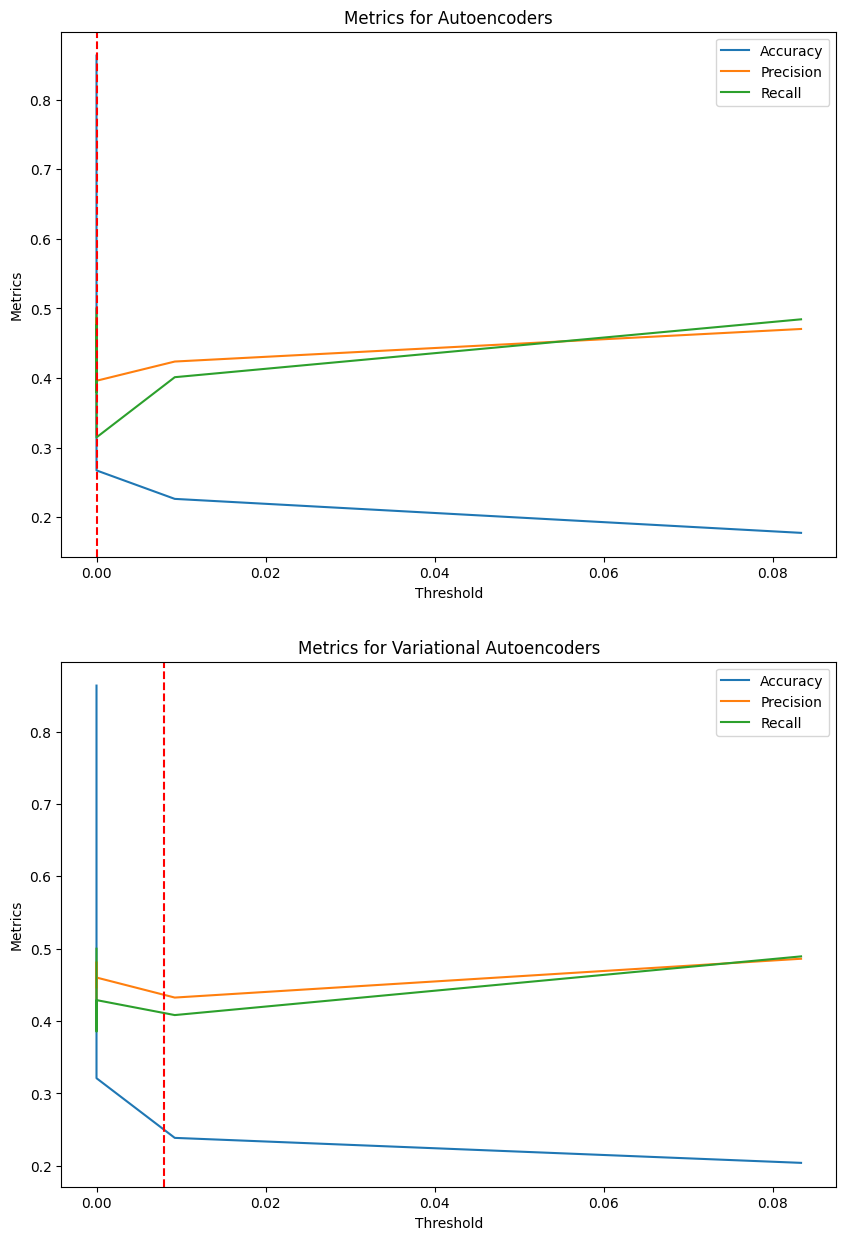

In [ ]:
# We plot our dataframes. You can see different threshold, and how this performs
# among accuracy, recall, precision
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# .plot. define ass x, y and label
# Autoencoders
axes[0].plot(thresh_AE['threshold'], thresh_AE['accuracy'], label='Accuracy')
axes[0].plot(thresh_AE['threshold'], thresh_AE['precision'], label='Precision')
axes[0].plot(thresh_AE['threshold'], thresh_AE['recall'], label='Recall')

axes[0].axvline(x=threshold_AE, color='r', linestyle='dashed')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Metrics')
axes[0].set_title('Metrics for Autoencoders')
axes[0].legend()

#Variational autoencoders
axes[1].plot(thresh_VAE['threshold'], thresh_VAE['accuracy'], label='Accuracy')
axes[1].plot(thresh_VAE['threshold'], thresh_VAE['precision'], label='Precision')
axes[1].plot(thresh_VAE['threshold'], thresh_VAE['recall'], label='Recall')

axes[1].axvline(x=threshold_VAE, color='r', linestyle='dashed')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Metrics')
axes[1].set_title('Metrics for Variational Autoencoders')
axes[1].legend()

In [ ]:
def thresholdTuning_probability(df, iterations):
    # create a dataframe that is able to collect: threshold, accuracy, precision,
                                                #recall
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        # Determine the threshold based on quantile values, progressively increasing it
        # https://www.tensorflow.org/api_docs/python/tf/keras/ops/quantile
        thresh_value = i/10
        # Generate predictions: True if reconstruction_error is above the threshold, False otherwise
        preds = df['probability'] < thresh_value
        # Compute classification metrics (accuracy, precision, recall)
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
        cr = classification_report(df['y_actual'], preds, output_dict=True)

        # Extract accuracy, precision, and recall
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        # Store the results in a dictionary with lists
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

    return pd.DataFrame(thresh_df)

thresh_GAN = thresholdTuning_probability(reconsGAN_df, 10)
threshold_GAN = thresh_GAN[thresh_GAN['recall'] == thresh_GAN['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall GAN: {threshold_GAN:.6f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Threshold with Maximum Recall GAN: 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

#Models evaluation


In [ ]:
# Given the selected threshold, we can create our predicton.
# Remember the algorithm...
# if error > threshold:
#        return "True"
#    else:
#        return "False"

**Evaluation Autoencoders**

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     39400
           1       0.86      1.00      0.93    249535

    accuracy                           0.86    288935
   macro avg       0.43      0.50      0.46    288935
weighted avg       0.75      0.86      0.80    288935



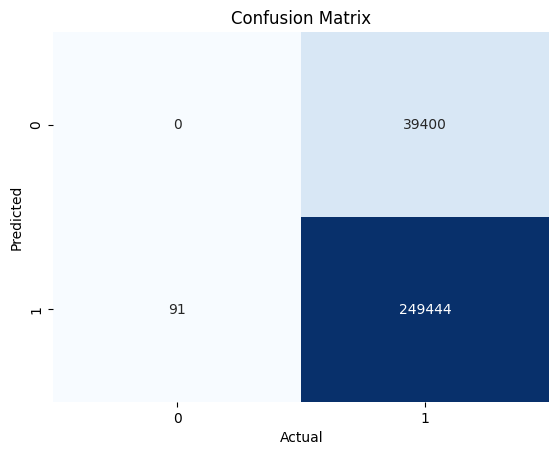

Recall is 99.964%
Accuracy is: 86.332%


In [ ]:
reconsAE_df['y_pred'] = reconsAE_df['reconstruction_error'] > threshold_AE
print(classification_report(reconsAE_df['y_actual'],reconsAE_df['y_pred']))
cm_AE = confusion_matrix(reconsAE_df['y_actual'],reconsAE_df['y_pred'])
sns.heatmap(cm_AE, annot=True, cmap='Blues', cbar=False, fmt='.6g')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print(f"Recall is {recall_score(reconsAE_df['y_actual'],reconsAE_df['y_pred'])*100:.3f}%")
print(f"Accuracy is: {accuracy_score(reconsAE_df['y_actual'],reconsAE_df['y_pred'])*100:.3f}%")

**Evaluation Variational Autoencoders**

              precision    recall  f1-score   support

           0       0.11      0.64      0.19     39400
           1       0.79      0.22      0.34    249535

    accuracy                           0.27    288935
   macro avg       0.45      0.43      0.27    288935
weighted avg       0.70      0.27      0.32    288935



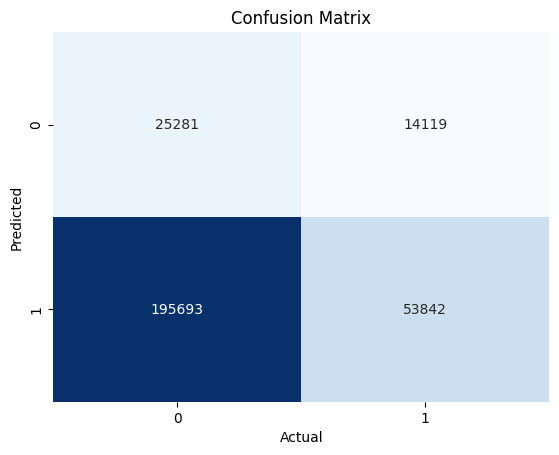

Recall is 21.577%
Accuracy is: 27.384%


In [ ]:
threshold_VAE = 0.008
reconsVAE_df['y_pred'] = reconsVAE_df['reconstruction_error'] > threshold_VAE
print(classification_report(reconsVAE_df['y_actual'],reconsVAE_df['y_pred']))
cm_VAE = confusion_matrix(reconsVAE_df['y_actual'],reconsVAE_df['y_pred'])
sns.heatmap(cm_VAE, annot=True, cmap='Blues', cbar=False, fmt='.6g')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print(f"Recall is {recall_score(reconsVAE_df['y_actual'],reconsVAE_df['y_pred'])*100:.3f}%")
print(f"Accuracy is: {accuracy_score(reconsVAE_df['y_actual'],reconsVAE_df['y_pred'])*100:.3f}%")

**Evaluation GAN**

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     39400
           1       0.86      1.00      0.93    249535

    accuracy                           0.86    288935
   macro avg       0.43      0.50      0.46    288935
weighted avg       0.75      0.86      0.80    288935



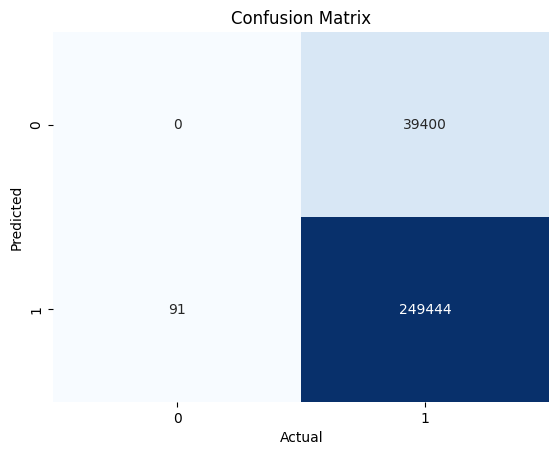

Recall is 100.000%
Accuracy is: 86.364%


In [ ]:
reconsGAN_df['y_pred'] = reconsGAN_df['probability'] < 0.6
print(classification_report(reconsGAN_df['y_actual'],reconsGAN_df['y_pred']))
cm_GAN = confusion_matrix(reconsAE_df['y_actual'],reconsAE_df['y_pred'])
sns.heatmap(cm_GAN, annot=True, cmap='Blues', cbar=False, fmt='.6g')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print(f"Recall is {recall_score(reconsGAN_df['y_actual'],reconsGAN_df['y_pred'])*100:.3f}%")
print(f"Accuracy is: {accuracy_score(reconsGAN_df['y_actual'],reconsGAN_df['y_pred'])*100:.3f}%")